In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.models as models

import os

import cv2
import matplotlib.pyplot as plt
from PIL import Image

from albumentations.pytorch import ToTensorV2
import albumentations as A

import numpy as np

from tqdm import tqdm

import torchvision.models as models

from typing import List

In [2]:
class LyftUdacity(Dataset):
    def __init__(self,img_dir,transform = None):
        self.transforms = transform
        image_paths = [i+'/CameraRGB' for i in img_dir]
        seg_paths = [i+'/CameraSeg' for i in img_dir]
        self.images,self.masks = [],[]
        
        for i in image_paths:
            imgs = os.listdir(i)
            self.images.extend([i+'/'+img for img in imgs])
        for i in seg_paths:
            masks = os.listdir(i)
            self.masks.extend([i+'/'+mask for mask in masks])
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img = np.array(Image.open(self.images[index]))
        mask = np.array(Image.open(self.masks[index]))
        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            mask = torch.max(mask,dim=2)[0]
            
        return img,mask

In [3]:
data_dir = ['data/Semantic Segmentation for Self Driving Cars/data'+i+'/data'+i for i in ['A','B','C','D','E']]

In [4]:
def get_images(image_dir,transform = None,batch_size=16,shuffle=True,pin_memory=True):
    data = LyftUdacity(image_dir,transform = t1)
    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_batch,test_batch

In [5]:
t1 = A.Compose([
    A.Resize(224,224),
    A.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [6]:
data_train,data_test = get_images(data_dir, transform=t1, batch_size=16)

In [7]:
class BottleneckBlock(nn.Module):
    def __init__(self, nc, rate: int):
        super().__init__()
        self.act = nn.ReLU()
        
        self.conv0 = nn.Conv2d(nc, nc//4, kernel_size=1, padding=0)
        self.norm0 = nn.BatchNorm2d(nc//4)
        self.conv1 = nn.Conv2d(nc//4, nc//4, kernel_size=3, padding=rate, dilation=rate)
        self.norm1 = nn.BatchNorm2d(nc//4)
        self.conv2 = nn.Conv2d(nc//4, nc, kernel_size=1, padding=0)
        self.norm2 = nn.BatchNorm2d(nc)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.norm2(out)
        
        return self.act(x + out)

In [8]:
class ResTruck(nn.Module):
    def __init__(self, nc, num_blocks, rate: int = 1):
        super(ResTruck, self).__init__()
        
        truck = []

        for i in range(num_blocks):
            truck += [BottleneckBlock(nc, rate=rate)]

        self.truck = nn.Sequential(*truck)
        
    def forward(self, x):        
        return self.truck(x)

In [9]:
class ResNet(nn.Module):
    def __init__(self, in_nc, nc):
        super(ResNet, self).__init__()
        
        self.conv0 = nn.Conv2d(in_nc, nc, kernel_size=7, stride=2, padding=3)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.ReLU()
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)

        self.layer1 = ResTruck(nc, 3)
        self.conv1 = nn.Conv2d(nc, nc*2, 1, padding=0, stride=2)
        self.layer2 = ResTruck(nc*2, 4)
        self.conv2 = nn.Conv2d(nc*2, nc*4, 1, padding=0, stride=2)
        self.layer3 = ResTruck(nc*4, 6, rate=2)
        self.conv3 = nn.Conv2d(nc*4, nc*8, 1, padding=0, stride=2)
        self.layer4 = ResTruck(nc*8, 3, rate=4)
        self.conv4 = nn.Conv2d(nc*8, 2048, 1, padding=0, stride=2)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        #out = self.maxpool(out)
        out = self.layer1(out)
        out = self.conv1(out)
        #print(out.shape)
        out = self.layer2(out)
        out = self.conv2(out)
        #print(out.shape)
        out = self.layer3(out)
        out = self.conv3(out)
        #print(out.shape)
        out = self.layer4(out)
        out = self.conv4(out)
        #print(out.shape)
        return out

In [10]:
class ASPPConv(nn.Module):
    def __init__(self, nc: int, out_nc: int, kernel_size: int = 1, rate: int = 1):
        super().__init__()
        
        self.conv0 = nn.Conv2d(nc, out_nc, kernel_size=kernel_size, padding=rate, dilation=rate)
        self.norm0 = nn.BatchNorm2d(out_nc)
        self.act = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        return self.act(out)

In [11]:
class ASPPPooling(nn.Module):
    def __init__(self, nc: int, out_nc: int, kernel_size: int = 1):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.conv0 = nn.Conv2d(nc, out_nc, kernel_size=kernel_size)
        self.norm0 = nn.BatchNorm2d(out_nc)
        self.act = nn.ReLU()
        
    def forward(self, x):
        size = x.shape[-2:]
        out = self.avgpool(x)
        out = self.conv0(out)
        out = self.norm0(out)
        out = self.act(out)
        return F.interpolate(out, size=size, mode="bilinear", align_corners=False)

In [12]:
class ASPPModule(nn.Module):
    def __init__(self, in_channels, atrous_rates: List[int], out_channels: int = 256):
        super(ASPPModule, self).__init__()
        # Диляционные свертки с разными дилетациями
        self.ASPP_conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False),
                                        nn.BatchNorm2d(out_channels),
                                        nn.ReLU())
        self.ASPP_conv2 = ASPPConv(in_channels, out_channels, kernel_size = 3, rate = atrous_rates[0])
        self.ASPP_conv3 = ASPPConv(in_channels, out_channels, kernel_size = 3, rate = atrous_rates[1])
        self.ASPP_conv4 = ASPPConv(in_channels, out_channels, kernel_size = 3, rate = atrous_rates[2])
        
        # 1x1 свертка для сжатия признаков
        self.ASPP_pool5 = ASPPPooling(in_channels, out_channels)

        # Слой для классификации
        self.project = nn.Sequential(
            nn.Conv2d(5 * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

    def forward(self, x):
        feature1 = self.ASPP_conv1(x)
        feature2 = self.ASPP_conv2(x)
        feature3 = self.ASPP_conv3(x)
        feature4 = self.ASPP_conv4(x)
        feature5 = self.ASPP_pool5(x)

        out = torch.cat((feature1, feature2, feature3, feature4, feature5), dim=1)
    
        return self.project(out)

In [13]:
class DeepLabHead(nn.Module):
    def __init__(self, nc: int, num_classes: int):
        super().__init__()
        self.ASPPModule = ASPPModule(nc, [12, 24, 36])
        
        self.conv0 = nn.Conv2d(256, 256, 3, padding=1)
        self.norm0 = nn.BatchNorm2d(256)
        self.act = nn.ReLU()
        self.conv1 = nn.Conv2d(256, num_classes, kernel_size=1)
        
    def forward(self, x):
        out = self.ASPPModule(x)
        out = self.conv0(out)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)

        return out

In [14]:
# class FCNHead(nn.Module):
#     def __init__(self, in_channels: int, channels: int):
#         super().__init__(*layers)
#         inter_channels = in_channels // 4

#         self.conv0 = nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
#         self.norm0 = nn.BatchNorm2d(inter_channels),
#         self.act = nn.ReLU(),
#         self.drop = nn.Dropout(0.1),
#         self.conv1 = nn.Conv2d(inter_channels, channels, 1),
        

In [15]:
resnet50 = models.resnet50(pretrained=True)

d:\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
backbone = nn.Sequential(*list(resnet50.children())[:-2])

In [17]:
class DeepLabV3(nn.Module):
    def __init__(self, num_classes: int, backbone = None):
        super(DeepLabV3, self).__init__()

        self.backbone = ResNet(3, 64)
        
        if backbone is not None:
            self.backbone = backbone
        
        self.DeepLabHead = DeepLabHead(2048, num_classes)
         
        self.FCNHead = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1, inplace=False),
            nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
        )
    
    def forward(self, x):
        input_shape = x.shape[-2:]

        out = self.backbone(x)
        out = self.DeepLabHead(out)
        #out = self.FCNHead(out)
        out = F.interpolate(out, size=input_shape, mode="bilinear", align_corners=False)
        
        return out

In [20]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

42001242

In [20]:
device = 'cuda'
num_classes = 13
model = DeepLabV3(num_classes, backbone)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)



In [21]:
epochs = 100

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(data_train)):
        X, y = sample
        
        X = X.to(device)
        y = y.type(torch.LongTensor)
        y = y.to(device)
        
        

        pred = model(X)
        loss = loss_fn(pred, y)
        
        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item
        
        optimizer.step()
        optimizer.zero_grad()
        
        pbar.set_description(f'loss: {loss_item:.5f}')
    
    scheduler.step()
    
    print(f'epoch: {epoch + 1}')    
    print(f'loss: {loss_val/len(data_train)}')

loss: 0.43958: 100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


epoch: 1
loss: 0.6057790964841843


loss: 0.35660: 100%|██████████| 250/250 [01:51<00:00,  2.24it/s]


epoch: 2
loss: 0.39315714383125305


loss: 0.31401: 100%|██████████| 250/250 [01:51<00:00,  2.25it/s]


epoch: 3
loss: 0.3493462529182434


loss: 0.30900: 100%|██████████| 250/250 [01:46<00:00,  2.36it/s]


epoch: 4
loss: 0.32695037603378296


loss: 0.32420: 100%|██████████| 250/250 [01:48<00:00,  2.29it/s]


epoch: 5
loss: 0.3098531864881516


loss: 0.28684: 100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


epoch: 6
loss: 0.2973189069032669


loss: 0.26166: 100%|██████████| 250/250 [01:49<00:00,  2.28it/s]


epoch: 7
loss: 0.2892754068374634


loss: 0.27221: 100%|██████████| 250/250 [01:50<00:00,  2.27it/s]


epoch: 8
loss: 0.28485193973779677


loss: 0.28557: 100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


epoch: 9
loss: 0.2786923784613609


loss: 0.29996: 100%|██████████| 250/250 [01:50<00:00,  2.27it/s]


epoch: 10
loss: 0.2723211750984192


loss: 0.27533: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


epoch: 11
loss: 0.26768377649784086


loss: 0.26718: 100%|██████████| 250/250 [01:43<00:00,  2.41it/s]


epoch: 12
loss: 0.26351398968696593


loss: 0.25413: 100%|██████████| 250/250 [01:45<00:00,  2.37it/s]


epoch: 13
loss: 0.2601186264753342


loss: 0.25787: 100%|██████████| 250/250 [01:44<00:00,  2.38it/s]


epoch: 14
loss: 0.25743617457151413


loss: 0.26062: 100%|██████████| 250/250 [01:44<00:00,  2.38it/s]


epoch: 15
loss: 0.2553794094920158


loss: 0.26090: 100%|██████████| 250/250 [01:45<00:00,  2.37it/s]


epoch: 16
loss: 0.25598396480083463


loss: 0.27937: 100%|██████████| 250/250 [01:44<00:00,  2.39it/s]


epoch: 17
loss: 0.25410638749599457


loss: 0.26862: 100%|██████████| 250/250 [01:44<00:00,  2.40it/s]


epoch: 18
loss: 0.25176712435483933


loss: 0.26751: 100%|██████████| 250/250 [01:44<00:00,  2.39it/s]


epoch: 19
loss: 0.2493063880801201


loss: 0.25660: 100%|██████████| 250/250 [01:45<00:00,  2.38it/s]


epoch: 20
loss: 0.24737381970882416


loss: 0.24197: 100%|██████████| 250/250 [01:44<00:00,  2.40it/s]


epoch: 21
loss: 0.24545138245821


loss: 0.25769: 100%|██████████| 250/250 [01:44<00:00,  2.38it/s]


epoch: 22
loss: 0.24374326831102372


loss: 0.21232: 100%|██████████| 250/250 [01:44<00:00,  2.38it/s]


epoch: 23
loss: 0.24236732393503188


loss: 0.23013: 100%|██████████| 250/250 [01:44<00:00,  2.39it/s]


epoch: 24
loss: 0.24090934777259826


loss: 0.26133: 100%|██████████| 250/250 [01:44<00:00,  2.39it/s]


epoch: 25
loss: 0.23995973300933837


loss: 0.26909: 100%|██████████| 250/250 [01:44<00:00,  2.38it/s]


epoch: 26
loss: 0.23870334053039552


loss: 0.24798: 100%|██████████| 250/250 [01:45<00:00,  2.37it/s]


epoch: 27
loss: 0.23788539856672286


loss: 0.20092: 100%|██████████| 250/250 [01:45<00:00,  2.37it/s]


epoch: 28
loss: 0.23704628431797028


loss: 0.24327: 100%|██████████| 250/250 [01:45<00:00,  2.36it/s]


epoch: 29
loss: 0.23629328501224517


loss: 0.23510: 100%|██████████| 250/250 [01:44<00:00,  2.39it/s]


epoch: 30
loss: 0.23553223139047622


loss: 0.25485: 100%|██████████| 250/250 [01:44<00:00,  2.38it/s]


epoch: 31
loss: 0.23499783194065094


loss: 0.24959: 100%|██████████| 250/250 [01:44<00:00,  2.38it/s]


epoch: 32
loss: 0.23715929925441742


loss: 0.25950: 100%|██████████| 250/250 [01:51<00:00,  2.25it/s]


epoch: 33
loss: 0.23705833679437638


loss: 0.25001: 100%|██████████| 250/250 [01:49<00:00,  2.28it/s]


epoch: 34
loss: 0.2361144359111786


loss: 0.26574: 100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


epoch: 35
loss: 0.23513431012630462


loss: 0.21484: 100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


epoch: 36
loss: 0.23431089216470719


loss: 0.22625: 100%|██████████| 250/250 [01:48<00:00,  2.30it/s]


epoch: 37
loss: 0.23370316237211228


loss: 0.21527: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


epoch: 38
loss: 0.23281684756278992


loss: 0.21603: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


epoch: 39
loss: 0.2323247841000557


loss: 0.23019: 100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


epoch: 40
loss: 0.23178801727294923


loss: 0.21864:  31%|███       | 78/250 [00:33<01:14,  2.30it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


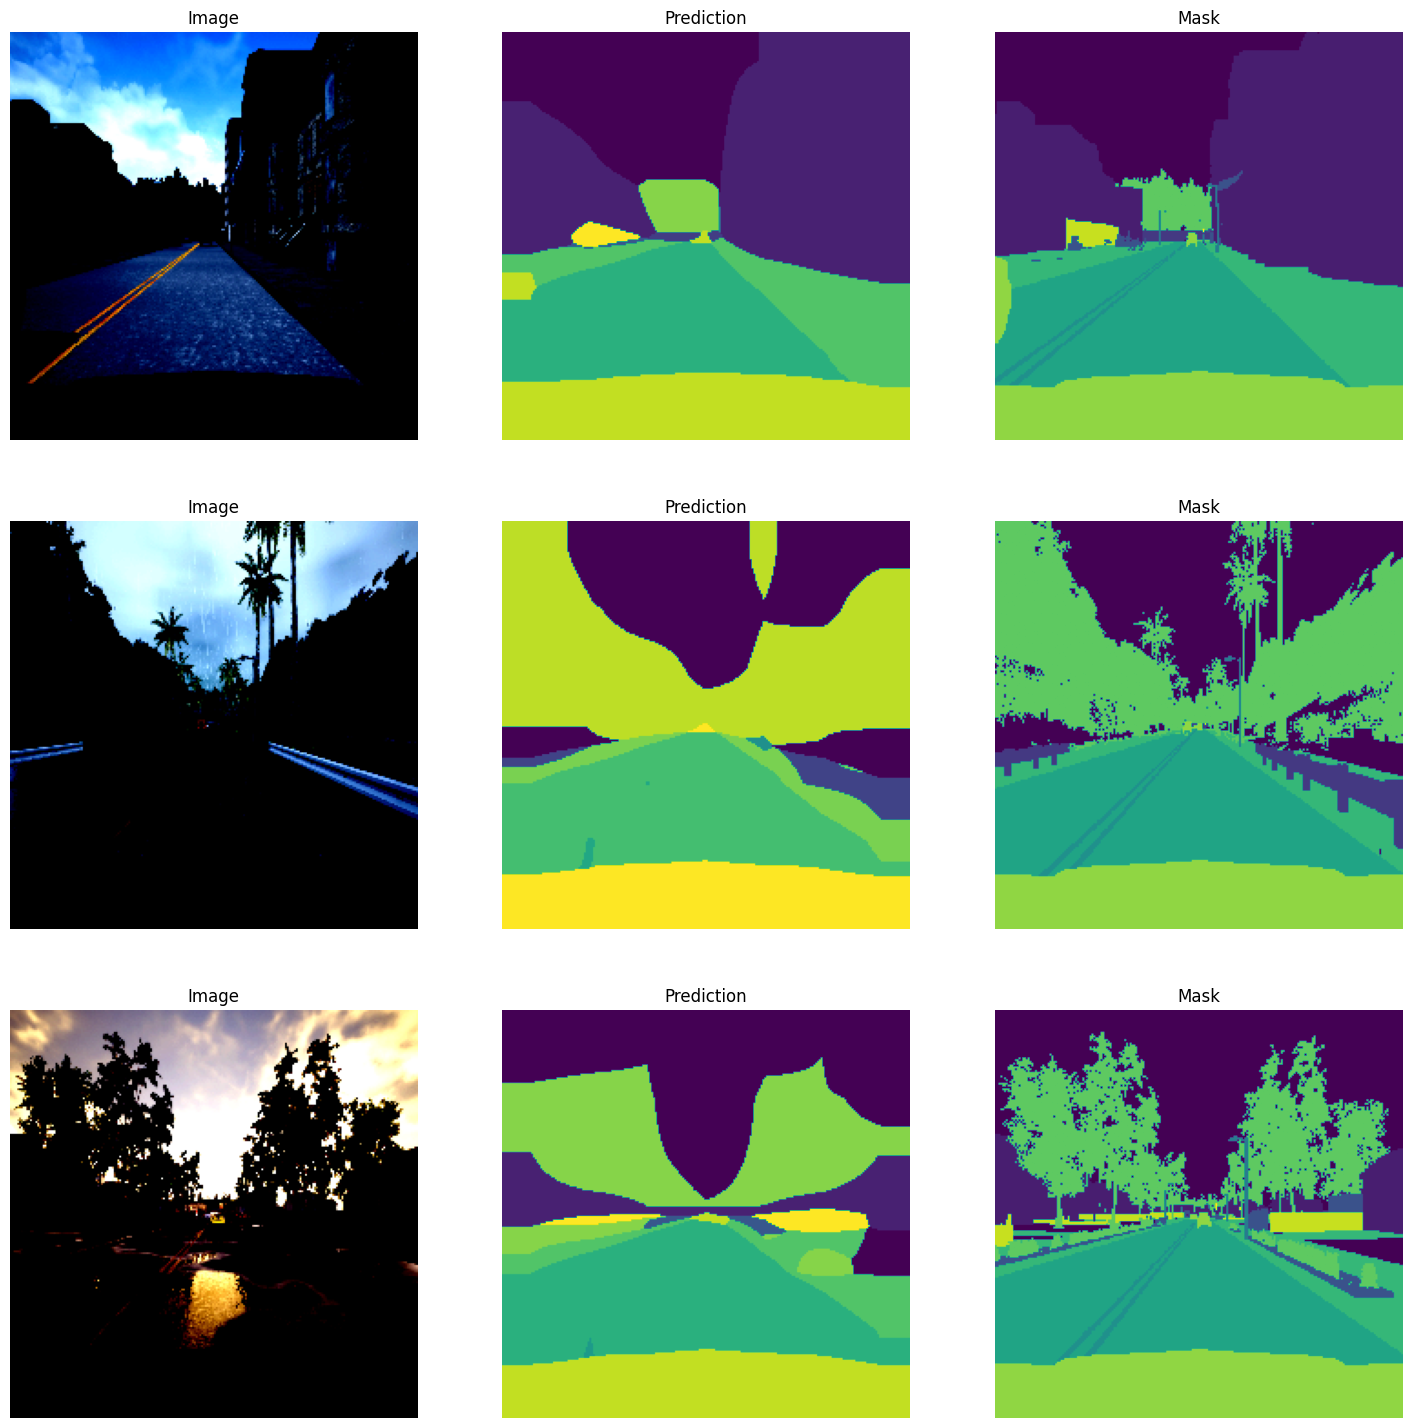

In [22]:
for x,y in data_test:
    x = x.to(device)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break